In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from kmodes.kprototypes import KPrototypes
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


In [37]:
# 1. 데이터 불러오기
df = pd.read_csv(
    # "C:/Users/Admin/Desktop/이정수/LG U+/프로젝트3/data/0.perfume_preprocessed.csv", # 정수
    "C:/Users/Admin/Desktop/PROJ/data/02_cleaned/perfume/2.perfume_limited_mainaccord_filtered.csv", # 원선
    # encoding="cp949",
)

### [K-Prototype] Top + mainaccord 1,2,3 

c:\Users\Admin\anaconda3\envs\mycleanenv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



▶ K = 5 모델 학습 시작
➡ K=5 | K-Prototypes Cost = 791.8411607235196
➡ K=5 | Silhouette (numeric only) = 0.298452396450839

▶ K = 6 모델 학습 시작
➡ K=6 | K-Prototypes Cost = 741.7035217637164
➡ K=6 | Silhouette (numeric only) = 0.33403293133137085

▶ K = 7 모델 학습 시작
➡ K=7 | K-Prototypes Cost = 714.6520114398916
➡ K=7 | Silhouette (numeric only) = 0.35355397161606994

▶ K = 8 모델 학습 시작
➡ K=8 | K-Prototypes Cost = 693.3748143184547
➡ K=8 | Silhouette (numeric only) = 0.3707627602379573

▶ K = 9 모델 학습 시작
➡ K=9 | K-Prototypes Cost = 659.6177452308333
➡ K=9 | Silhouette (numeric only) = 0.3880303215367317

▶ K = 10 모델 학습 시작
➡ K=10 | K-Prototypes Cost = 644.8071306251551
➡ K=10 | Silhouette (numeric only) = 0.3998440335043998

▶ K = 11 모델 학습 시작
➡ K=11 | K-Prototypes Cost = 627.0399444016289
➡ K=11 | Silhouette (numeric only) = 0.4161162196697854

▶ K = 12 모델 학습 시작
➡ K=12 | K-Prototypes Cost = 603.0034362180648
➡ K=12 | Silhouette (numeric only) = 0.43167043097886504

▶ K = 13 모델 학습 시작
➡ K=13 | K-Prototy

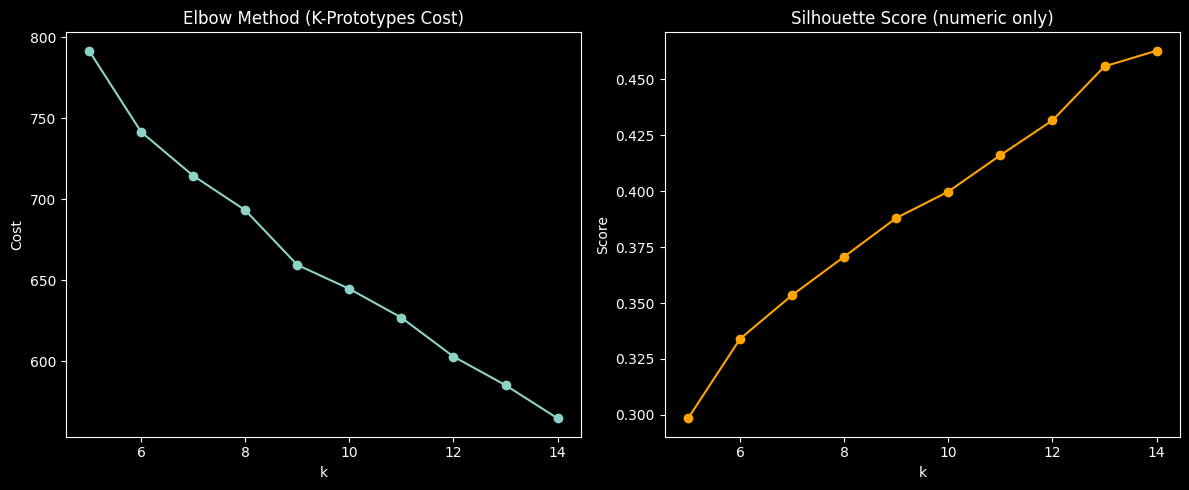

In [49]:
# -----------------------------------------------------------
# 1) Middle 컬럼 → TF-IDF 전처리
# -----------------------------------------------------------
df["Middle_list"] = df["Middle"].apply(lambda x: x.split(","))

Middle_tags = [tag for tags in df["Middle_list"] for tag in tags]
tag_counts = Counter(Middle_tags)

MIN_FREQ = 25
high_freq_tags = {tag for tag, cnt in tag_counts.items() if cnt >= MIN_FREQ}

df["Middle_filtered"] = df["Middle_list"].apply(
    lambda tags: " ".join([t for t in tags if t in high_freq_tags])
)

vectorizer_Middle = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
X_Middle = vectorizer_Middle.fit_transform(df["Middle_filtered"])
X_Middle = normalize(X_Middle)

# -----------------------------------------------------------
# 2) accord_cols는 범주형 그대로 사용
# -----------------------------------------------------------
accord_cols = [
    "mainaccord1",
    "mainaccord2",
    "mainaccord3",
]

for c in accord_cols:
    df[c] = df[c].fillna("None").astype(str)

X_acc = df[accord_cols].values

# -----------------------------------------------------------
# 3) 수치형 + 범주형 결합
# -----------------------------------------------------------
X_Middle_dense = X_Middle.toarray()
X_total = np.hstack([X_Middle_dense, X_acc])

num_numeric = X_Middle_dense.shape[1]
categorical_idx = list(range(num_numeric, num_numeric + len(accord_cols)))

# -----------------------------------------------------------
# 4) Elbow + Silhouette + Cost 출력
# -----------------------------------------------------------
K_range = range(5, 15)
costs = []
sil_scores = []

for k in K_range:
    print("\n===============================")
    print(f"▶ K = {k} 모델 학습 시작")
    print("===============================")

    kp = KPrototypes(n_clusters=k, random_state=42, init='Huang')
    labels = kp.fit_predict(X_total, categorical=categorical_idx)

    # Cost 저장 + 출력
    cost_val = kp.cost_
    costs.append(cost_val)
    print(f"➡ K={k} | K-Prototypes Cost = {cost_val}")

    # Silhouette 계산
    sil = silhouette_score(X_Middle_dense, labels)
    sil_scores.append(sil)
    print(f"➡ K={k} | Silhouette (numeric only) = {sil}")

# -----------------------------------------------------------
# K별 cost 요약 출력
# -----------------------------------------------------------
print("\n=======================================")
print("📌 전체 K별 Cost 요약")
print("=======================================")
for k, c in zip(K_range, costs):
    print(f"K={k} → Cost={c}")

# -----------------------------------------------------------
# 5) 시각화
# -----------------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, costs, marker='o')
plt.title("Elbow Method (K-Prototypes Cost)")
plt.xlabel("k")
plt.ylabel("Cost")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o', color='orange')
plt.title("Silhouette Score (numeric only)")
plt.xlabel("k")
plt.ylabel("Score")

plt.tight_layout()
plt.show()
